# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, auc,confusion_matrix, f1_score
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

import re
from nltk.corpus import stopwords

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
from scipy.sparse import find
from sklearn.model_selection import train_test_split, TimeSeriesSplit, validation_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('./Dataset/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

def findMinorClassPoints(df):
    posCount = int(df[df['Score']==1].shape[0]);
    negCount = int(df[df['Score']==0].shape[0]);
    if negCount < posCount:
        return negCount
    return posCount

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#Performing Downsampling
samplingCount = findMinorClassPoints(filtered_data)
postive_df = filtered_data[filtered_data['Score'] == 1].sample(n=samplingCount)
negative_df = filtered_data[filtered_data['Score'] == 0].sample(n=samplingCount)

filtered_data = pd.concat([postive_df, negative_df])

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (164074, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
465769,503603,B007PSZCX0,AOHE4N43YY81O,George J. Kenney,0,0,1,1349827200,Love This Blend,Whole bean Decaf Verona is a strong decaf that...
326764,353650,B005A1LINC,A2L35P0VQE7LBN,nowann,0,0,1,1317859200,A Hit At The Office,I wasn't expecting anything different with thi...
346162,374472,B004XNZLYA,A1VUQDXH27Z26G,K. Paul,0,0,1,1283731200,Chicken w/sweet Potato is the best!,I have purchased this product several times. ...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(128360, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

78.23299243024489

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(128360, 10)


1    71249
0    57111
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
I planted them, the grassy plants grew well. Lots of healthy plants....only my cats showed absolutely no interest in them!
Here's a list of everything that's wrong with my tree<br />*infested with fungus gnat larvae<br />*yellowing leaf's<br />*wiring marks on the trunk<br />*not 8 to 9 inches<br />* delivered in 5 days not two day shipment<br />*might have root rot<br /><br />All I hope is that my poor little tree will make it.you would think I would want to return my tree but I don't want to give up on it yet :)<br /><a href="http://www.amazon.com/gp/product/B0000DGG1U">Brussel's CT9005CE Chinese Elm Bonsai</a>
This would be a great litter box for some litters, especially with the double bottom trays that make cleaning easier.  However, contrary to a previ

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
I planted them, the grassy plants grew well. Lots of healthy plants....only my cats showed absolutely no interest in them!
Here's a list of everything that's wrong with my tree*infested with fungus gnat larvae*yellowing leaf's*wiring marks on the trunk*not 8 to 9 inches* delivered in 5 days not two day shipment*might have root rotAll I hope is that my poor little tree will make it.you would think I would want to return my tree but I don't want to give up on it yet :)Brussel's CT9005CE Chinese Elm Bonsai
This would be a great litter box for some litters, especially with the double bottom trays that make cleaning easier.  However, contrary to a previous review, I found this box bad for Feline Pine wood pellet litter.  The slots in the top sifting pan are exact

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Here is a list of everything that is wrong with my tree<br />*infested with fungus gnat larvae<br />*yellowing leaf is<br />*wiring marks on the trunk<br />*not 8 to 9 inches<br />* delivered in 5 days not two day shipment<br />*might have root rot<br /><br />All I hope is that my poor little tree will make it.you would think I would want to return my tree but I do not want to give up on it yet :)<br /><a href="http://www.amazon.com/gp/product/B0000DGG1U">Brussel is CT9005CE Chinese Elm Bonsai</a>


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Here is a list of everything that is wrong with my tree br infested with fungus gnat larvae br yellowing leaf is br wiring marks on the trunk br not 8 to 9 inches br delivered in 5 days not two day shipment br might have root rot br br All I hope is that my poor little tree will make it you would think I would want to return my tree but I do not want to give up on it yet br a href http www amazon com gp product B0000DGG1U Brussel is CT9005CE Chinese Elm Bonsai a 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 128360/128360 [00:54<00:00, 2343.08it/s]


In [23]:
preprocessed_reviews[1500]

'list everything wrong tree infested fungus gnat larvae yellowing leaf wiring marks trunk not inches delivered days not two day shipment might root rotall hope poor little tree make would think would want return tree not want give yet'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data
del positiveNegative
del postive_df
del negative_df

100%|██████████| 128360/128360 [00:02<00:00, 46088.64it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [27]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [29]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [30]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [34]:
global result_report
result_report = pd.DataFrame(columns=['VECTORIZER-MODEL', 'REGULARIZATION', 'HYPERPARAMETER', 'F1_SCORE', 'AUC'])

In [35]:
#Using only 100k points because of lack of resources
min_final = final.sample(n=100000)

#Sorting according to the time
min_final['Time'] = pd.to_datetime(min_final['Time'], unit='s')
min_final = min_final.sort_values(by='Time', ascending=True)


#Splitting the data into 70-30 train test ratio
x_train, x_test, y_train, y_test = train_test_split(min_final['CleanedText'], min_final['Score'], 
                                                    test_size=0.30, shuffle=False)

lambda_range = np.array(sorted([10 ** i for i in range(-5, 5, 1)]
                               + [2 ** i for i in range(-5, -2, 1)]))

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [36]:
bow_model = CountVectorizer()
bow_model.fit(x_train)

x_train_bow = bow_model.transform(x_train)
x_test_bow = bow_model.transform(x_test)

In [37]:
# Standardizing the dataset with mean centering and variance scaling
stnd_clf = StandardScaler(with_mean=False)
#Fitting and transforming the training dataset
x_train_bow = stnd_clf.fit_transform(x_train_bow)
#Transforming the testing dataset
x_test_bow = stnd_clf.transform(x_test_bow)

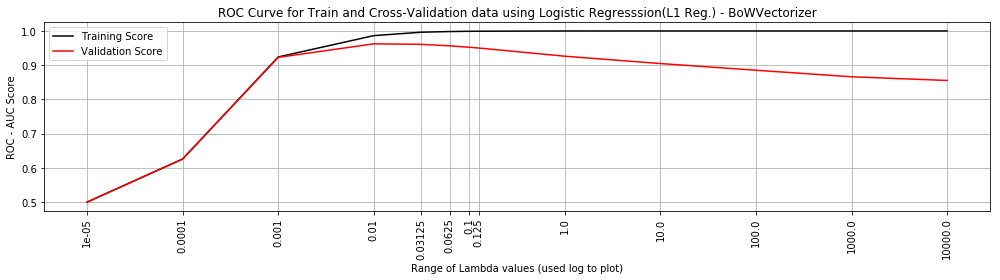

In [38]:
lr = LogisticRegression(penalty='l1', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(x_train_bow, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L1 Reg.) - BoWVectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal Lambda: 100.0 with AUC: 96.42%


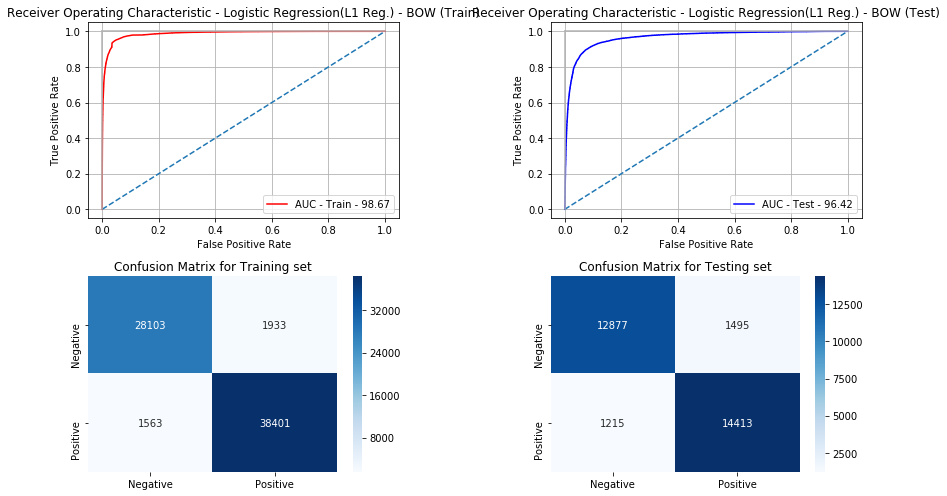

In [39]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l1', random_state=0, C=optimal_lambda)
clf.fit(x_train_bow, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(x_train_bow)
pred_test = clf.predict(x_test_bow)
pred_proba_train = clf.predict_proba(x_train_bow)[:,1]
pred_proba_test = clf.predict_proba(x_test_bow)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(float(1) / optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'Bag of Words(BoW)',
                                      'REGULARIZATION' : 'L1',
                                      'HYPERPARAMETER': float(1) / optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - BOW (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - BOW (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [40]:
w_optimal = clf.coef_[0]
total_count = w_optimal.shape[0]
zero_count = int((clf.coef_ == 0).sum())

print("Sparcity on weight vector obtained using L1 regularization on BOW = {:.2f}%".format(float(zero_count/total_count) * 100))

Sparcity on weight vector obtained using L1 regularization on BOW = 88.22%


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

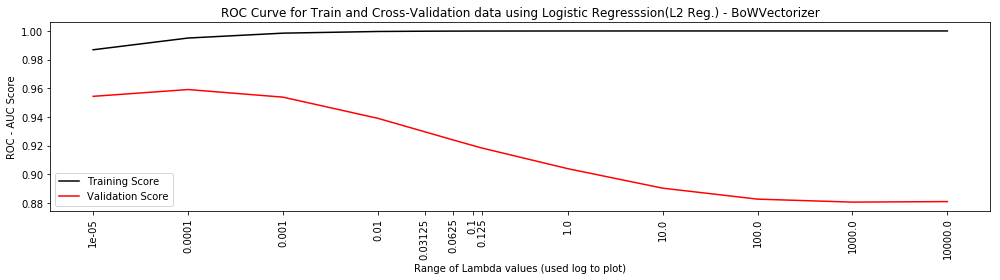

In [41]:
lr = LogisticRegression(penalty='l2', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(x_train_bow, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L2 Reg.) - BoWVectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal Lambda: 0.0001 with AUC: 95.48%


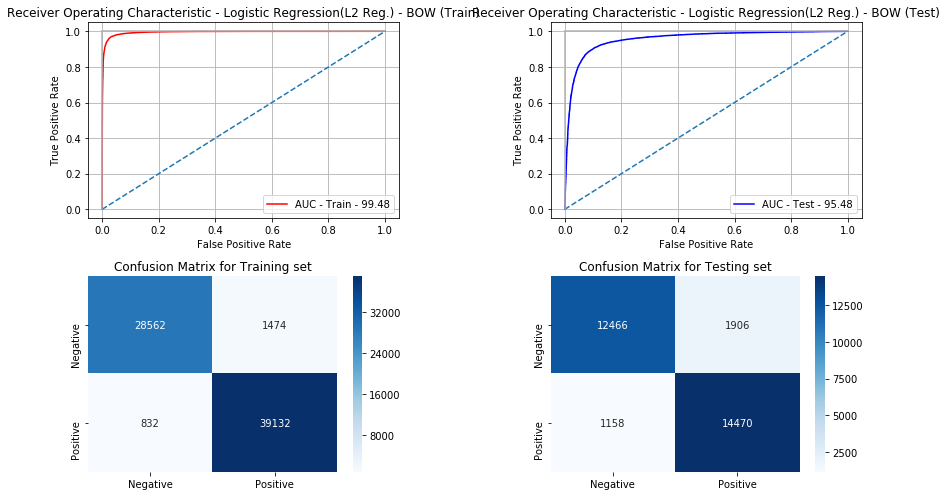

In [42]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l2', random_state=0, C=optimal_lambda)
clf.fit(x_train_bow, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(x_train_bow)
pred_test = clf.predict(x_test_bow)
pred_proba_train = clf.predict_proba(x_train_bow)[:,1]
pred_proba_test = clf.predict_proba(x_test_bow)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'Bag of Words(BoW)',
                                      'REGULARIZATION' : 'L2',
                                      'HYPERPARAMETER': optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - BOW (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - BOW (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

Difference in Weight Vector : [[0.07889714 0.00766526 0.18036001 ... 0.04407767 0.20778188 4.17245302]]


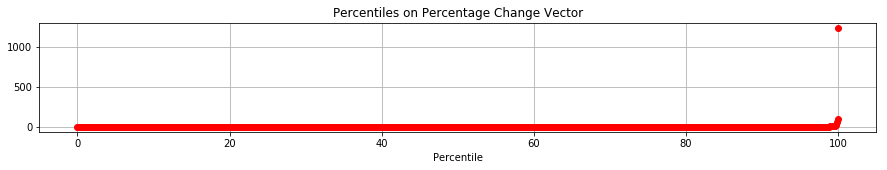

Selected value from Elbow Method with threshold change(1.5) is --> 9.685032680877576


The feature names whose % change is more than a threshold x(9.685032680877576) - 

['abouit', 'absorbed', 'addedthis', 'admiration', 'aeroccino', 'albertsons', 'alkyl', 'alkylating', 'alo', 'aloo', 'alpo', 'anatomic', 'ancestry', 'anchimeric', 'ancho', 'anomer', 'apauled', 'assorted', 'avoidbaby', 'awaygrossly', 'barium', 'barney', 'bettycrocker', 'bilirubin', 'bioavailable', 'bircherm', 'bloackege', 'bodyweight', 'booster', 'botulinum', 'branched', 'brewer', 'bridge', 'buri', 'burrowing', 'california', 'camelia', 'canceri', 'candybar', 'capture', 'capuccino', 'carcinogenicity', 'carcinomas', 'carnival', 'casue', 'chair', 'checkwith', 'chiefly', 'chung', 'chunkey', 'cites', 'cocky', 'colorectal', 'comfortable', 'competence', 'concentratemight', 'concoct', 'conservations', 'consumptionjittersinability', 'copycat', 'curative', 'cyanogenic', 'cystine', 'dazzling', 'debittered', 'definable', 'degeneratio

In [43]:
clf = LogisticRegression(C= optimal_lambda, penalty= 'l2')
clf.fit(x_train_bow,y_train)

#Adding some uniform small error
x_train_bow_new = x_train_bow.copy()
epsilon = 0.01
x_train_bow_new.data += epsilon

#Running LogisticRegression classfier with L2 reg again with the same optimal lambda
clf_err = LogisticRegression(C= optimal_lambda, penalty= 'l2')
clf_err.fit(x_train_bow_new,y_train)

old_clf_w = clf.coef_ + 0.000001
new_clf_w = clf_err.coef_ + 0.000001

clf_diff_w = (abs((old_clf_w - new_clf_w)/old_clf_w)) * 100
print("Difference in Weight Vector : {}".format(clf_diff_w))
clf_diff_w_sort = sorted(clf_diff_w[0], reverse=False)

plt.figure(figsize=(15, 2))
plt.title('Percentiles on Percentage Change Vector')
threshold = 1.5
val_elb = -1
found = False
ini = 0
for k in np.linspace(0,100,1000):
    val = np.percentile(clf_diff_w_sort, k)
    if ((abs(ini-val) > threshold) & (not found)):
        val_elb = val
        found = True
    
    ini = val
    plt.plot(k, val, 'ro')
    
plt.xlabel("Percentile")
plt.grid()
plt.show()

print("Selected value from Elbow Method with threshold change({}) is --> {}".format(threshold, val_elb))

feature_names = bow_model.get_feature_names()
features = []
for i, val in enumerate(clf_diff_w[0]):
    if val > val_elb:
        features.append(feature_names[i])
        
print("\n\nThe feature names whose % change is more than a threshold x({}) - \n\n{}".format(val_elb, features))

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [44]:
feature_names = bow_model.get_feature_names()
value_zips = sorted(zip(clf.coef_[0], feature_names))
value_zips[:10]

[(-0.1981554058789831, 'not'),
 (-0.1217960003988747, 'disappointed'),
 (-0.08907173202277903, 'worst'),
 (-0.08839335790069261, 'terrible'),
 (-0.08657397703115373, 'awful'),
 (-0.08338391788242532, 'disappointing'),
 (-0.08133429025709675, 'horrible'),
 (-0.0800043673567656, 'bad'),
 (-0.07704942486915016, 'money'),
 (-0.07143605052579492, 'stale')]

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [45]:
feature_names = bow_model.get_feature_names()
value_zips = sorted(zip(clf.coef_[0], feature_names), reverse=True)
value_zips[:10]

[(0.23694127532449027, 'great'),
 (0.16760516278351412, 'best'),
 (0.1419983820966942, 'love'),
 (0.14140725317169558, 'delicious'),
 (0.11983671191364832, 'good'),
 (0.11138266631143688, 'excellent'),
 (0.10506015019981235, 'loves'),
 (0.09744666419915599, 'perfect'),
 (0.0910337109473035, 'yummy'),
 (0.0904777957332719, 'favorite')]

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [46]:
tfidf_model = CountVectorizer(ngram_range=(1,2))
tfidf_model.fit(x_train)

x_train_tfidf = tfidf_model.transform(x_train)
x_test_tfidf = tfidf_model.transform(x_test)

In [47]:
# Standardizing the dataset with mean centering and variance scaling
stnd_clf = StandardScaler(with_mean=False)
#Fitting and transforming the training dataset
x_train_tfidf = stnd_clf.fit_transform(x_train_tfidf)
#Transforming the testing dataset
x_test_tfidf = stnd_clf.transform(x_test_tfidf)

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

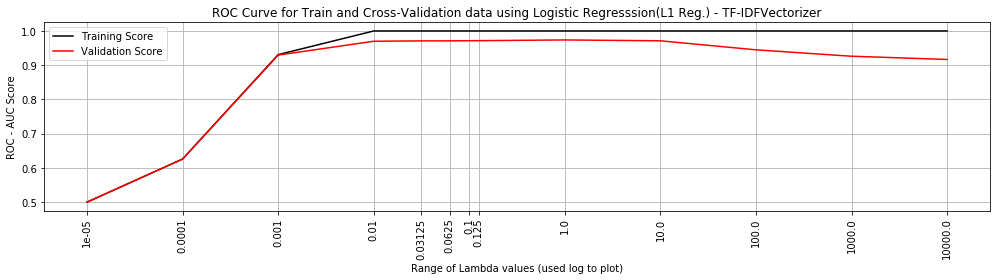

In [48]:
lr = LogisticRegression(penalty='l1', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(x_train_tfidf, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L1 Reg.) - TF-IDFVectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal Lambda: 1.0 with AUC: 97.55%


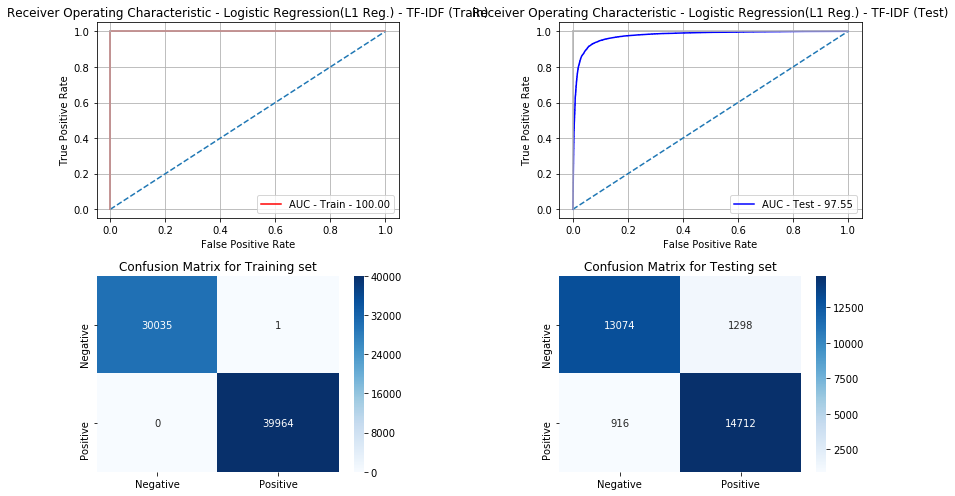

In [49]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l1', random_state=0, C=optimal_lambda)
clf.fit(x_train_tfidf, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(x_train_tfidf)
pred_test = clf.predict(x_test_tfidf)
pred_proba_train = clf.predict_proba(x_train_tfidf)[:,1]
pred_proba_test = clf.predict_proba(x_test_tfidf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(float(1) / optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'TF-IDF',
                                      'REGULARIZATION' : 'L1',
                                      'HYPERPARAMETER': float(1) / optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - TF-IDF (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - TF-IDF (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

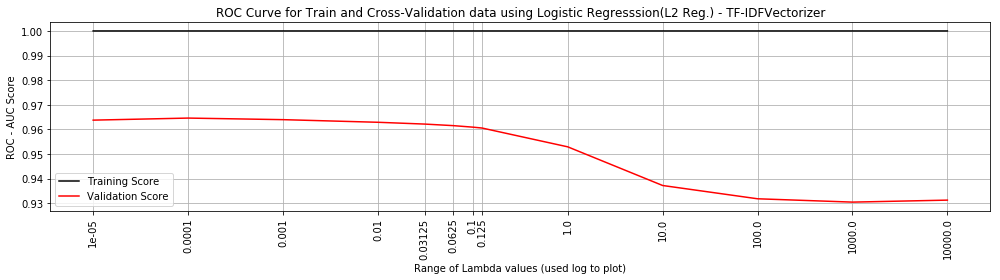

In [50]:
lr = LogisticRegression(penalty='l2', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(x_train_tfidf, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L2 Reg.) - TF-IDFVectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal Lambda: 10000.0 with AUC: 96.21%


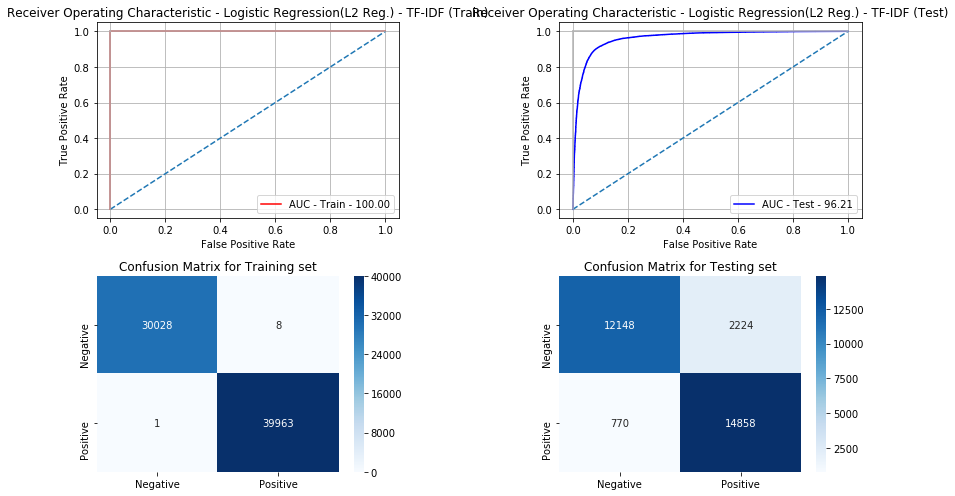

In [51]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l2', random_state=0, C=optimal_lambda)
clf.fit(x_train_tfidf, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(x_train_tfidf)
pred_test = clf.predict(x_test_tfidf)
pred_proba_train = clf.predict_proba(x_train_tfidf)[:,1]
pred_proba_test = clf.predict_proba(x_test_tfidf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(float(1) / optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'TF-IDF',
                                      'REGULARIZATION' : 'L2',
                                      'HYPERPARAMETER': float(1) / optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - TF-IDF (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - TF-IDF (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [52]:
feature_names = tfidf_model.get_feature_names()
value_zips = sorted(zip(clf.coef_[0], feature_names))
value_zips[:10]

[(-0.040931870428807554, 'not'),
 (-0.032082632414301884, 'not good'),
 (-0.03046070203830691, 'not buy'),
 (-0.03041527187667231, 'disappointed'),
 (-0.024021589090887984, 'not worth'),
 (-0.023972364197855575, 'would not'),
 (-0.02327856300045317, 'terrible'),
 (-0.022702533940154177, 'awful'),
 (-0.022585157173129637, 'worst'),
 (-0.022362640817383667, 'money')]

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [53]:
feature_names = tfidf_model.get_feature_names()
value_zips = sorted(zip(clf.coef_[0], feature_names), reverse=True)
value_zips[:10]

[(0.07086659387518637, 'great'),
 (0.04902098169511156, 'best'),
 (0.04571252931303575, 'love'),
 (0.03993327877989172, 'delicious'),
 (0.03355492961477897, 'good'),
 (0.031241303359079584, 'loves'),
 (0.0307051221773291, 'excellent'),
 (0.028406280993952933, 'yummy'),
 (0.028381768451539304, 'favorite'),
 (0.02691755048357479, 'perfect')]

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [54]:
list_of_sent_train = []
list_of_sent_test = []

for sent in x_train:
    list_of_sent_train.append(sent.split())
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=8)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16927
sample words  ['stover', 'valid', 'squirted', 'butcher', 'browns', 'ii', 'defeated', 'bay', 'apo', 'pursuit', 'spec', 'targets', 'viscosity', 'gaps', 'stylish', 'fructose', 'unpredictable', 'clicking', 'yorkshire', 'caffinated', 'sheepdog', 'shreds', 'bandit', 'uncertain', 'whoppers', 'fo', 'convincing', 'drove', 'repurchasing', 'protective', 'decisions', 'freaks', 'rigatoni', 'unaffected', 'translates', 'beloved', 'hassle', 'thrived', 'fibre', 'dunkin', 'unpleasantness', 'sauces', 'digestive', 'universe', 'enzyme', 'appeared', 'dog', 'lakewood', 'dew', 'game']


In [55]:
# compute average word2vec for each review for train data 
avgw2v_train = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train, ascii=True, desc="Training W2V"): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_train.append(sent_vec)

# compute average word2vec for each review for test data 
avgw2v_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test, ascii=True, desc="Testing W2V"): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_test.append(sent_vec)

Testing W2V: 100%|##########| 30000/30000 [09:31<00:00, 52.53it/s]


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

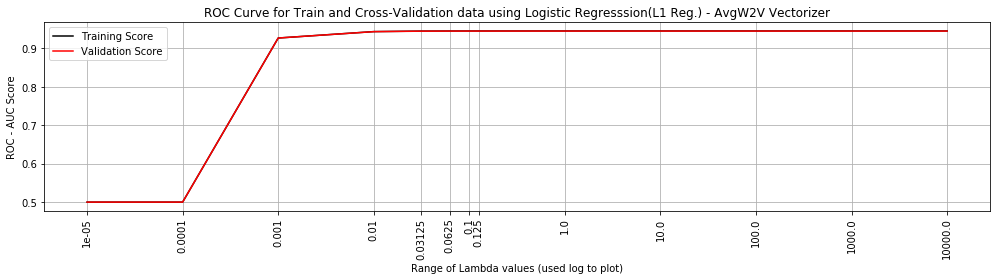

In [56]:
lr = LogisticRegression(penalty='l1', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(avgw2v_train, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L1 Reg.) - AvgW2V Vectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal Lambda: 0.001 with AUC: 94.52%


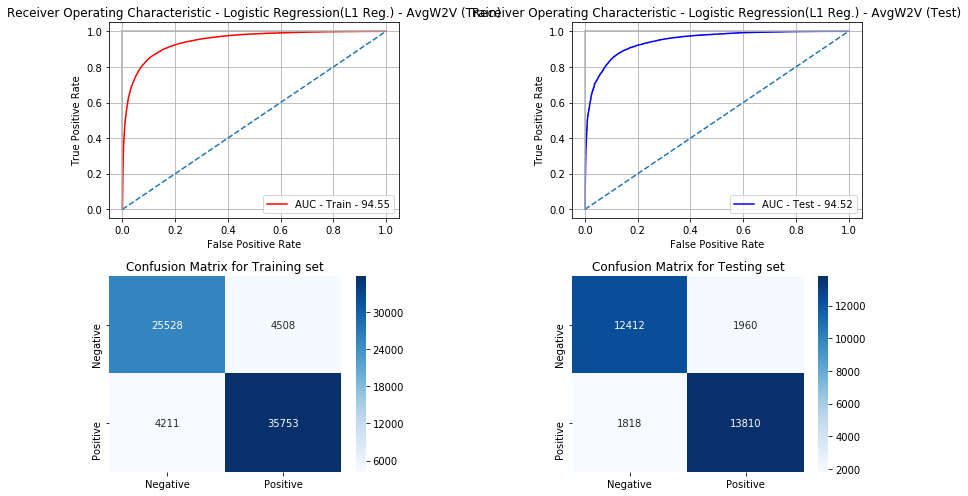

In [57]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l1', random_state=0, C=optimal_lambda)
clf.fit(avgw2v_train, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(avgw2v_train)
pred_test = clf.predict(avgw2v_test)
pred_proba_train = clf.predict_proba(avgw2v_train)[:,1]
pred_proba_test = clf.predict_proba(avgw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(float(1) / optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'Avg W2V',
                                      'REGULARIZATION' : 'L1',
                                      'HYPERPARAMETER': float(1) / optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - AvgW2V (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - AvgW2V (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

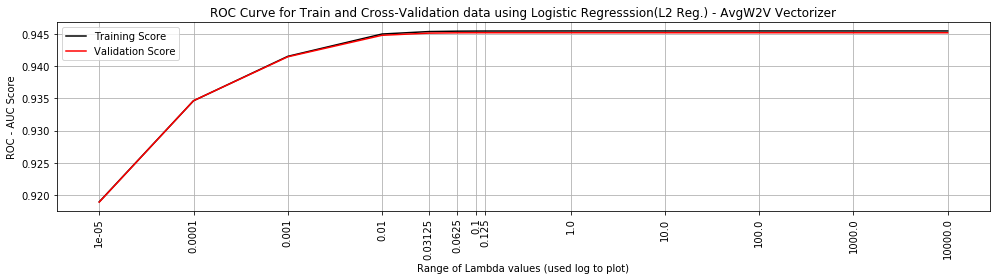

In [58]:
lr = LogisticRegression(penalty='l2', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(avgw2v_train, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L2 Reg.) - AvgW2V Vectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal Lambda: 8.0 with AUC: 94.52%


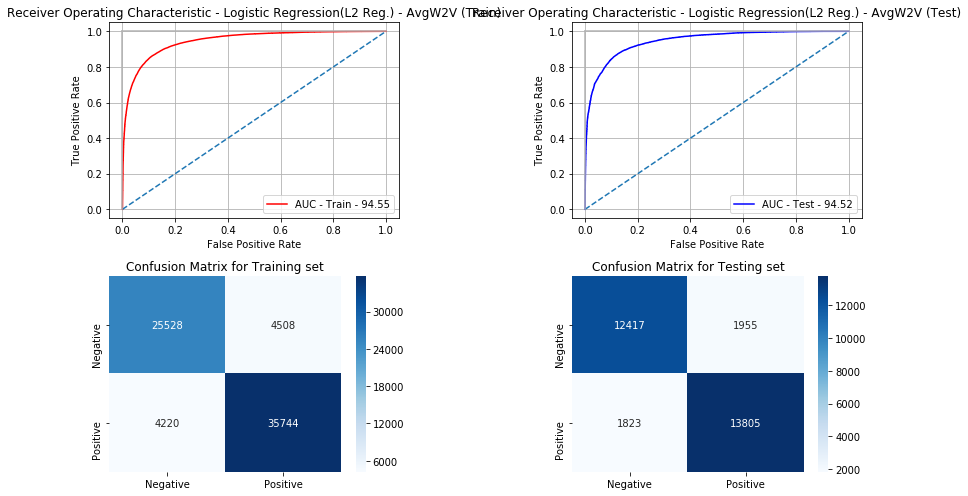

In [59]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l2', random_state=0, C=optimal_lambda)
clf.fit(avgw2v_train, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(avgw2v_train)
pred_test = clf.predict(avgw2v_test)
pred_proba_train = clf.predict_proba(avgw2v_train)[:,1]
pred_proba_test = clf.predict_proba(avgw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(float(1) / optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'Avg W2V',
                                      'REGULARIZATION' : 'L2',
                                      'HYPERPARAMETER': float(1) / optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - AvgW2V (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - AvgW2V (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [60]:
model = TfidfVectorizer()
model.fit(x_train)

#Creating the TFIDF W2V Training Set
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sent_train, ascii=True, desc="Training TFIDF W2V"): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_train.append(sent_vec)
    
tfidfw2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sent_test, ascii=True, desc="Testing TFIDF W2V"): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_test.append(sent_vec)


Testing TFIDF W2V: 100%|##########| 30000/30000 [35:46<00:00, 23.63it/s]  


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

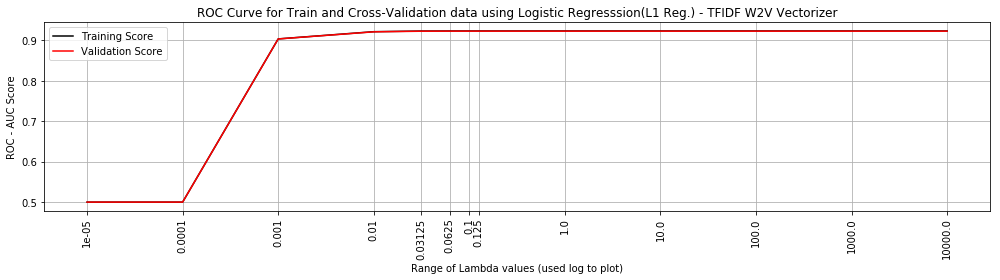

In [61]:
lr = LogisticRegression(penalty='l1', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(tfidfw2v_train, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L1 Reg.) - TFIDF W2V Vectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal Lambda: 8.0 with AUC: 91.96%


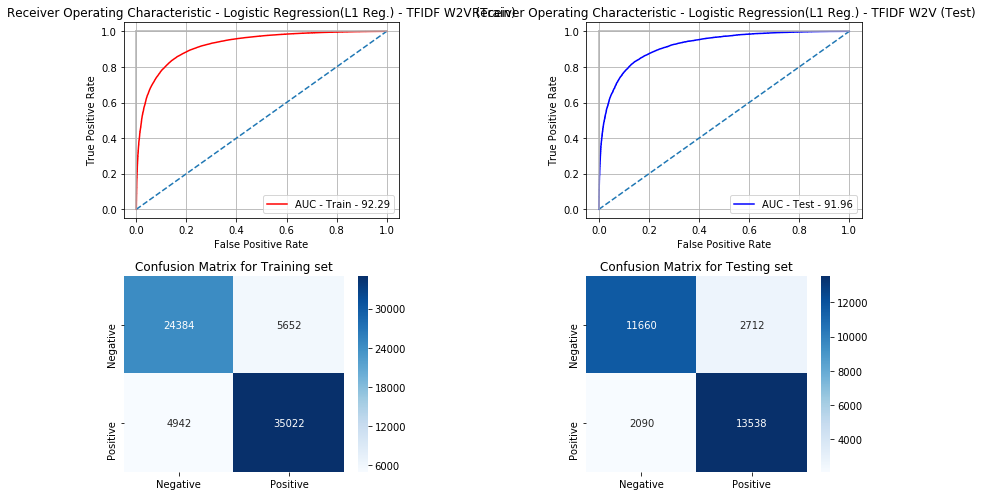

In [62]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l1', random_state=0, C=optimal_lambda)
clf.fit(tfidfw2v_train, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(tfidfw2v_train)
pred_test = clf.predict(tfidfw2v_test)
pred_proba_train = clf.predict_proba(tfidfw2v_train)[:,1]
pred_proba_test = clf.predict_proba(tfidfw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(float(1) / optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'TFIDF-W2V',
                                      'REGULARIZATION' : 'L1',
                                      'HYPERPARAMETER': float(1) / optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - TFIDF W2V (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L1 Reg.) - TFIDF W2V (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

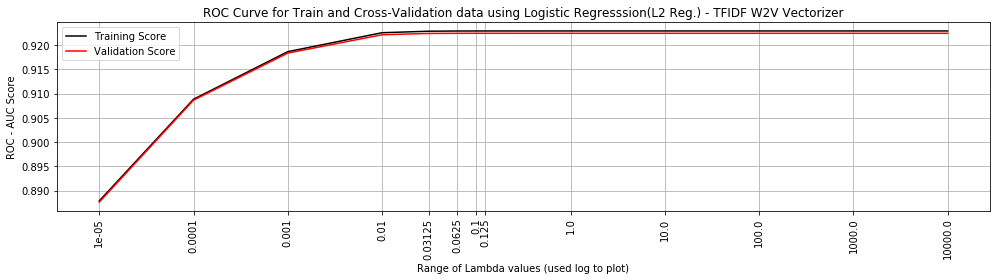

In [63]:
lr = LogisticRegression(penalty='l2', random_state=0)
parameters = {'C': lambda_range}
g_clf = GridSearchCV(lr, parameters, cv = 10, scoring='roc_auc', return_train_score=True, n_jobs=-1)
g_clf.fit(tfidfw2v_train, y_train)

mean_train_score = g_clf.cv_results_['mean_train_score']
mean_test_score = g_clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 4))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(lambda_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(lambda_range), mean_test_score, label='Validation Score', color='red')
plt.xticks(np.log(lambda_range), lambda_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Logistic Regresssion(L2 Reg.) - TFIDF W2V Vectorizer")
plt.xlabel("Range of Lambda values (used log to plot)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()

Optimal Lambda: 10.0 with AUC: 91.97%


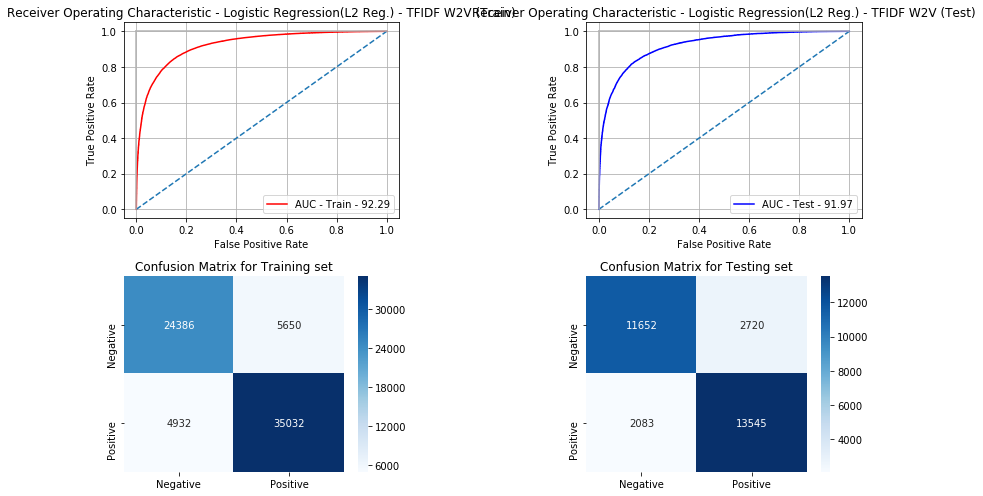

In [64]:
optimal_lambda = g_clf.best_params_['C']
clf = LogisticRegression(penalty='l2', random_state=0, C=optimal_lambda)
clf.fit(tfidfw2v_train, y_train)

# Get predicted values for train & test data
pred_train = clf.predict(tfidfw2v_train)
pred_test = clf.predict(tfidfw2v_test)
pred_proba_train = clf.predict_proba(tfidfw2v_train)[:,1]
pred_proba_test = clf.predict_proba(tfidfw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Lambda: {} with AUC: {:.2f}%".format(float(1) / optimal_lambda, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER-MODEL': 'TFIDF-W2V',
                                      'REGULARIZATION' : 'L2',
                                      'HYPERPARAMETER': float(1) / optimal_lambda,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - TFIDF W2V (Train)')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for testing set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Logistic Regression(L2 Reg.) - TFIDF W2V (Test)')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for training set
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for testing set
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

# [6] Conclusions

In [65]:
result_report

,VECTORIZER-MODEL,REGULARIZATION,HYPERPARAMETER,F1_SCORE,AUC
0,Bag of Words(BoW),L1,100.0000,0.914066,0.964219
1,Bag of Words(BoW),L2,0.0001,0.904262,0.954771
2,TF-IDF,L1,1.0000,0.930021,0.975476
3,TF-IDF,L2,10000.0000,0.908468,0.962065
4,Avg W2V,L1,0.0010,0.879674,0.945203
5,Avg W2V,L2,8.0000,0.879636,0.945206
6,TFIDF-W2V,L1,8.0000,0.849363,0.919636
7,TFIDF-W2V,L2,10.0000,0.849403,0.919660


**'C' (1/lambda) values for Logistic Regression Algorithm were taken to be in the range**

[1.000e-05, 1.000e-04, 1.000e-03, 1.000e-02, 3.125e-02, 6.250e-02,1.000e-01, 1.250e-01, 1.000e+00, 1.000e+01, 1.000e+02, 1.000e+03,1.000e+04]